### Kaggle Notebook Titanic

1. 필요한 라이브러리와 데이터 로드

In [4]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# PySpark - SQL
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit

# PySpark - ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Spark의 첫 시작인 SparkSession 만들기
spark = (SparkSession.builder
                    .appName('Play with pyspark ML on Titanic Data')
                    .getOrCreate())

# Load Data
df = spark.read.csv('./Data/titanic/train.csv', header=True, inferSchema=True)
# toPandas()를 이용해 판다스에서 제공하는 데이터프레임형태로 출력
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


## Matplotlib, Seaborn을 활용한 간단한 시각화

pandas_df 타입: <class 'pandas.core.frame.DataFrame'>


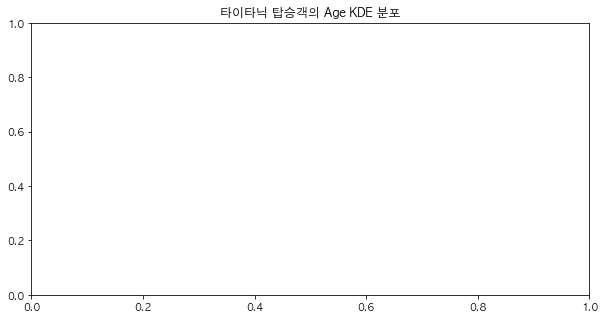

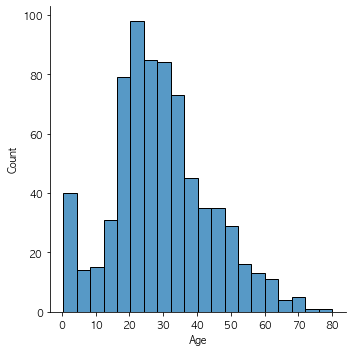

In [5]:
# Pandas 데이터프레임 형태로 우선 변환하기
pandas_df = df.toPandas()
print("pandas_df 타입:", type(pandas_df))

# Seaborn 사용해보기
plt.figure(figsize=(10, 5))
plt.title("타이타닉 탑승객의 Age KDE 분포")
sns.displot(pandas_df['Age'])
plt.show()

## 3. PySpark로 결측치 체크하고 기존 변수로부터 파생변수 생성하기
---
- 결측치를 체크하기 위해서는 물론 Spark의 데이터프레임 형태를 Pandas 형태의 데이터프레임 형태로 바꾼 후 평소 사용했던 Pandas API에서 제공하는 결측치 확인 메소드를 사용해도 된다.
- 하지만 PySpark에 대해 익숙해짐이 목적이므로 Spark의 데이터프레임 형태에서 결측치를 체크하는 방법에 대해 알아본다.

1. isnan(): pyspark.sql.functions - isnan('column name')
2. isNull(): pyspark.sql.Column - col('column name').isNull()

In [6]:
from pyspark.sql.functions import isnan, count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show() 

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



- 위 코드에서 `when()` 메서드가 등장하는데 `filter()` 메서드와 비슷한 기능을 한다고 볼 수 있다.
- 추가적으로 불필요한 컬럼인 Cabin을 없애기 위해 `drop()` 메서드를 사용할 수 있다.

In [7]:
# Cabin 변수는 결측치가 50%가 넘기 때문에 삭제
df = df.drop('Cabin')